In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from pylab import *
import copy
import time

torch.manual_seed(1)                      # reproducible
torch.set_printoptions(threshold=np.inf)  # print all


# ----- Step 1: Set Hyper Parameters ----- #

model = 'LSTM'
dataset = 'ItalyPowerDemand'
NAME = f'{model}-UCR-{dataset}'

train_data_path = f'../Datasets/UCR/{dataset}/{dataset}_TRAIN.tsv'
test_data_path = f'../Datasets/UCR/{dataset}/{dataset}_TEST.tsv'

BATCH_SIZE = 200  # 150
LR = 0.001

TIME_STEP = 24
INPUT_SIZE = 1
OUTPUT_SIZE = 2


# ----- Step 2: Dataset Loading and Preprocessing ----- #

class GetLoader(torch.utils.data.Dataset):      # 定义GetLoader类，继承Dataset方法

    def __init__(self, data_root, data_label):  # 初始化，加载数据
        self.data = data_root
        self.label = data_label

    def __getitem__(self, index):               # index是根据batchsize划分数据得到的索引
        data = self.data[index]
        labels = self.label[index]
        return data, labels

    def __len__(self):                          # 返回数据大小长度，方便DataLoader划分
        return len(self.data)

    
train_text = ''
test_text = ''

train_x = []
train_y = []
test_x = []
test_y = []

with open(train_data_path, 'r') as f:
    train_text = f.read()
train_lines = train_text.split('\n')
for line in train_lines:
    _list = line.split('\t')
    if len(_list) > 1:
        train_y.append(float(_list[0])-1)
        flo_list = [[float(num)] for num in _list[1:]]
        train_x.append(flo_list)

with open(test_data_path, 'r') as f:
    test_text = f.read()
test_lines = test_text.split('\n')
for line in test_lines:
    _list = line.split('\t')
    if len(_list) > 1:
        test_y.append(float(_list[0])-1)
        flo_list = [[float(num)] for num in _list[1:]]
        test_x.append(flo_list)
        
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

# for i in range(len(train_y)):  # special pre-processing bacause of the format of the original dataset
#     if train_y[i] == -1:
#         train_y[i] = 1
        
# for i in range(len(test_y)):
#     if test_y[i] == -1:
#         test_y[i] = 1

print('*** Dataset Information ***\ntrain_x:', train_x.shape, '\ntrain_y:', train_y.shape, '\ntest_x:', test_x.shape, '\ntest_y:', test_y.shape)


# 留作每50轮输出当前训练结果用
train_X = copy.deepcopy(train_x)
train_X = torch.from_numpy(train_X).to(torch.float32)
train_Y = copy.deepcopy(train_y)
test_X = torch.from_numpy(test_x).to(torch.float32)
test_Y = test_y

train_x = torch.from_numpy(train_x).to(torch.float32)
train_y = torch.from_numpy(train_y).to(torch.long)
train_data = GetLoader(train_x, train_y)                # 返回Dataset对象(包含data和label)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

train_Y1 = copy.deepcopy(train_y)


# ----- Step 3: Create Model Class ----- #

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=128,
            num_layers=1,
            batch_first=True
        )
        self.out = nn.Linear(128, OUTPUT_SIZE)

    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)  # None represents zero initial hidden state
        out = self.out(r_out[:, -1, :])        # choose r_out at the last time step
        out_trace = self.out(r_out)            # choose r_out at all time steps
        return out, out_trace


# ----- Step 4: Instantiate ----- #

rnn = RNN()
print('\n*** Model Information ***\n', rnn, '\n\n*** Training Information ***')

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()   # the target label is not one-hotted


# ----- Step 5: Model Training ----- #

for turns in range(1, 201):
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        
        train_x = train_x.view(-1, TIME_STEP, INPUT_SIZE)
        output, _ = rnn(train_x)
        loss = loss_fn(output, train_y)
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()        # backward and compute gradients
        optimizer.step()       # apply gradients

        train_output, _ = rnn(train_X)
        pred_train_y = torch.max(train_output, 1)[1].data.numpy()
        train_accuracy = float((pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)
        train_loss = loss_fn(train_output, train_Y1)

        torch.save(rnn, f'../Models/{NAME}/epoch_{turns}_{batch_idx}.pkl')
        print('Epoch: ', turns, '_', batch_idx, '| train loss: %.4f' % train_loss.data.numpy(), '| train accuracy: %.2f' % train_accuracy)



*** Dataset Information ***
train_x: (67, 24, 1) 
train_y: (67,) 
test_x: (1029, 24, 1) 
test_y: (1029,)

*** Model Information ***
 RNN(
  (rnn): LSTM(1, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=2, bias=True)
) 

*** Training Information ***
Epoch:  1 _ 0 | train loss: 0.6900 | train accuracy: 0.51
Epoch:  2 _ 0 | train loss: 0.6885 | train accuracy: 0.52
Epoch:  3 _ 0 | train loss: 0.6870 | train accuracy: 0.54
Epoch:  4 _ 0 | train loss: 0.6856 | train accuracy: 0.58
Epoch:  5 _ 0 | train loss: 0.6840 | train accuracy: 0.60
Epoch:  6 _ 0 | train loss: 0.6824 | train accuracy: 0.60
Epoch:  7 _ 0 | train loss: 0.6807 | train accuracy: 0.63
Epoch:  8 _ 0 | train loss: 0.6788 | train accuracy: 0.67
Epoch:  9 _ 0 | train loss: 0.6767 | train accuracy: 0.69
Epoch:  10 _ 0 | train loss: 0.6743 | train accuracy: 0.70
Epoch:  11 _ 0 | train loss: 0.6717 | train accuracy: 0.72
Epoch:  12 _ 0 | train loss: 0.6686 | train accuracy: 0.72
Epoch:  13 _ 0 | train loss: 0

KeyboardInterrupt: 

In [2]:
"""
Finding The Optimum Model Automatically

"""

min_loss = 10000
max_test_acc = 0
corresponding_train_acc = 0

turns_chosen = -1
batch_idx_chosen = -1

for turns in range(81, 91):
    batch_number = int(train_X.shape[0]/BATCH_SIZE)
    if train_X.shape[0] % BATCH_SIZE != 0:
        batch_number += 1
    
    for batch_idx in range(batch_number):
        rnn = torch.load(f'../Models/{NAME}/epoch_{turns}_{batch_idx}.pkl')
        
        train_output, _ = rnn(train_X)
        pred_train_y = torch.max(train_output, 1)[1].data.numpy()
        train_accuracy = float((pred_train_y == train_Y).astype(int).sum()) / float(train_Y.size)
        train_loss = loss_fn(train_output, train_Y1)
        
        test_output, _ = rnn(test_X)
        pred_test_y = torch.max(test_output, 1)[1].data.numpy()
        test_accuracy = float((pred_test_y == test_Y).astype(int).sum()) / float(test_Y.size)
        
        test_acc_bias = test_accuracy - max_test_acc
        loss_bias = train_loss.data.numpy() - min_loss
        if test_acc_bias >= 0.01 or (test_acc_bias >= 0 and test_acc_bias < 0.01 and loss_bias < 0.1):
            max_test_acc = test_accuracy
            min_loss = train_loss.data.numpy()
            corresponding_train_acc = train_accuracy
            turns_chosen = turns
            batch_idx_chosen = batch_idx

print('*** The Optimum Model ***\nEpoch Index: ', turns_chosen, '_', batch_idx_chosen)
print('Train Loss: %.6f' % min_loss, '\nTrain Accuracy: %.4f' % corresponding_train_acc, '\nTest Accuracy: %.4f' % max_test_acc)


*** The Optimum Model ***
Epoch Index:  88 _ 0
Train Loss: 0.043879 
Train Accuracy: 0.9701 
Test Accuracy: 0.9650


In [3]:
rnn = torch.load(f'../Models/{NAME}/epoch_{turns_chosen}_{batch_idx_chosen}.pkl')

adv_data_path = f'../Datasets/UCR-ADV/BIM/{dataset}-adv'
adv_text = ''
adv_x = []
adv_y = []

with open(adv_data_path, 'r') as f:
    adv_text = f.read()
adv_lines = adv_text.split('\n')
for line in adv_lines:
    _list = line.split(',')
    if len(_list) > 1:
        adv_y.append(float(_list[0])-1)
        flo_list = [[float(num)] for num in _list[1:]]
        adv_x.append(flo_list)
        
adv_x = np.array(adv_x)
adv_y = np.array(adv_y)

print('*** Dataset Information ***\nadv_x:', adv_x.shape, '\nadv_y:', adv_y.shape)

adv_X = torch.from_numpy(adv_x).to(torch.float32)
adv_Y = adv_y


adv_output, _ = rnn(adv_X)
pred_adv_y = torch.max(adv_output, 1)[1].data.numpy()
adv_accuracy = float((pred_adv_y == adv_Y).astype(int).sum()) / float(adv_Y.size)

print('accuracy: %.6f' % adv_accuracy)


*** Dataset Information ***
adv_x: (1029, 24, 1) 
adv_y: (1029,)
accuracy: 0.931973


In [4]:
sum_distance = 0
for i in range(adv_X.shape[0]):
    for j in range(adv_X.shape[1]):
        sum_distance += abs(adv_X[i, j, 0] - test_X[i, j, 0])
average_distance = sum_distance / test_X.shape[0]
print('\n Average Perturbation:', average_distance)


 Average Perturbation: tensor(2.3419)


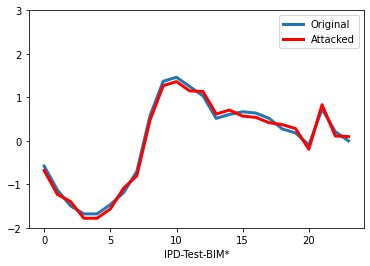

In [16]:
LABEL = 'IPD'
timestep_record = [i for i in range(train_X.shape[1])]


plt.plot(timestep_record, test_X[-1], '-', linewidth=3, color='#1f77b4', label='Original')
plt.plot(timestep_record, adv_X[-1], '-', linewidth=3, color='red', label='Attacked')
plt.xlabel(f"{LABEL}-Test-BIM*")
plt.ylim(-2, 3)
plt.legend()
plt.savefig(f'../Savefig/{LABEL}-BIM.png', bbox_inches='tight', dpi=600)
plt.show()

In [5]:
# Avg Sample and Avg Distance

sum_test_X_0 = test_X[0] - test_X[0]
sum_test_X_1 = test_X[0] - test_X[0]
count_test_X_0 = 0
count_test_X_1 = 0
for i in range(test_X.shape[0]):
    if test_Y[i] == 0:
        count_test_X_0 += 1
        sum_test_X_0 += test_X[i]
    if test_Y[i] == 1:
        count_test_X_1 += 1
        sum_test_X_1 += test_X[i]
avg_test_X_0 = sum_test_X_0 / count_test_X_0
avg_test_X_1 = sum_test_X_1 / count_test_X_1

distance_test_X_0 = 0
distance_test_X_1 = 0
for i in range(test_X.shape[0]):
    current_distance = 0
    if test_Y[i] == 0:
        for j in range(test_X.shape[1]):
            current_distance += abs(test_X[i, j, 0] - avg_test_X_0[j, 0])
        distance_test_X_0 += current_distance
    if test_Y[i] == 1:
        for j in range(test_X.shape[1]):
            current_distance += abs(test_X[i, j, 0] - avg_test_X_1[j, 0])
        distance_test_X_1 += current_distance
avg_distance_test_X_0 = distance_test_X_0 / count_test_X_0
avg_distance_test_X_1 = distance_test_X_1 / count_test_X_1

print(avg_distance_test_X_0)
print(avg_distance_test_X_1)


# Only Adv

self_distance = 0
other_distance = 0

for i in range(test_X.shape[0]):
    if pred_adv_y[i] == test_Y[i]:
        continue

    if test_Y[i] == 0:
        self_avg_train_X = avg_test_X_0
        other_avg_train_X = avg_test_X_1
        self_avg_distance = avg_distance_test_X_0
        other_avg_distance = avg_distance_test_X_1
    else:
        self_avg_train_X = avg_test_X_1
        other_avg_train_X = avg_test_X_0
        self_avg_distance = avg_distance_test_X_1
        other_avg_distance = avg_distance_test_X_0

    current_self_distance = 0
    for j in range(test_X.shape[1]):
        current_self_distance += abs(adv_X[i, j, 0] - self_avg_train_X[j, 0])
    self_distance += current_self_distance / self_avg_distance
    
    current_other_distance = 0
    for j in range(test_X.shape[1]):
        current_other_distance += abs(adv_X[i, j, 0] - other_avg_train_X[j, 0])
    other_distance += current_other_distance / other_avg_distance

cam_rate =  self_distance / other_distance
print('\n BIM Cam Rate:', cam_rate)
print(self_distance)
print(other_distance)


tensor(5.9349)
tensor(8.6987)

 BIM Cam Rate: tensor(1.0261)
tensor(81.9919)
tensor(79.9098)
